# Imports

In [1]:
import json
from functools import reduce
from os import listdir
from os.path import isfile, join
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tabulate
from pylab import rcParams
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
from IPython.display import display, HTML

# Setup

In [3]:
# Set figure size
rcParams['figure.figsize'] = (4, 4)

# Folder for images
Path('img').mkdir(parents=True, exist_ok=True)

# Nice float format
pd.options.display.float_format = "{:,.2f}".format

# Data description

Last year I purchased a Polar watch that tracks my vitals during workouts. I used the [Polar Flow](polar.flow.com) website to obtain a copy of my data. For privacy reasons I shall not be sharing the dataset.

In [4]:
path = './data/'

First, we create a list of files in the download.

In [5]:
files = [f for f in listdir(path) if isfile(join(path, f))]

We shall only consider files containing the string `'training-session'`.

In [6]:
files = [f for f in files if 'training-session' in f]

The number of files under consideration is:

In [7]:
len(files)

284

We loop over each of the files and them to a list.

In [8]:
data = []

for f in files:
    with open(join(path, f)) as f:
        d = json.load(f)
        data.append(d)

We define a function to extract statistics about heart rate measured during the workouts.

In [9]:
quantiles = [0.01, 0.25, 0.5, 0.75, 0.99]

In [10]:
def extract_hr_info(workout, quantiles):
    
    stats = {'heartRateAvg2': np.nan,
             'heartRateStd': np.nan}    

    for q in quantiles:
        stats[f'heartRateQ' + str(int(q * 100))] = np.nan
    
    # Check if data exists
    try:
        heart_rates = workout['exercises'][0]['samples']['heartRate']    
    except KeyError:
        return stats
     
    # Loop over measurements
    hr_data = []
    for hr in heart_rates:
        
        # Check if actually measured hr
        if 'value' in hr:
            hr_data.append(hr['value'])    

    stats['heartRateAvg2'] = np.mean(hr_data)
    stats['heartRateStd'] = np.std(hr_data)
    
    for q in quantiles:
        stats[f'heartRateQ' + str(int(q * 100))] = np.quantile(hr_data, q)
    
    return stats

We extract the relevant information from the items in the list.

In [11]:
workouts = []

for d in data:
    basic = d['exercises'][0]
    hr = extract_hr_info(workout=d, 
                         quantiles=quantiles)
    
    workouts.append({**basic, **hr})

Finally we create a dataframe containing the workout information.

In [12]:
df = pd.DataFrame(workouts)

# Data structure

We find the following columns in the dataframe.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   startTime       284 non-null    object 
 1   stopTime        284 non-null    object 
 2   timezoneOffset  284 non-null    int64  
 3   duration        284 non-null    object 
 4   sport           284 non-null    object 
 5   kiloCalories    283 non-null    float64
 6   heartRate       283 non-null    object 
 7   zones           284 non-null    object 
 8   samples         284 non-null    object 
 9   heartRateAvg2   283 non-null    float64
 10  heartRateStd    283 non-null    float64
 11  heartRateQ1     283 non-null    float64
 12  heartRateQ25    283 non-null    float64
 13  heartRateQ50    283 non-null    float64
 14  heartRateQ75    283 non-null    float64
 15  heartRateQ99    283 non-null    float64
 16  distance        130 non-null    float64
 17  latitude        130 non-null    flo

We remove columns that containt data from features I do not use in my training.

Due to privacy concerns I shan't be extracting longitudinal and latitudinal data.

In [14]:
df = df.drop(['zones', 'samples', 'autoLaps', 
              'laps', 'latitude', 'longitude', 
              'ascent', 'descent'], axis=1)

In [15]:
df.head()

,startTime,stopTime,timezoneOffset,duration,sport,kiloCalories,heartRate,heartRateAvg2,heartRateStd,heartRateQ1,heartRateQ25,heartRateQ50,heartRateQ75,heartRateQ99,distance,speed
0,2019-05-24T13:18:14.000,2019-05-24T14:58:44.125,120,PT6030.125S,STRENGTH_TRAINING,658.00,"{'min': 72, 'avg': 105, 'max': 136}",104.77,11.28,77.00,99.00,105.00,111.00,132.00,nan,NaN
1,2019-05-04T12:03:34.000,2019-05-04T13:21:38.500,120,PT4684.500S,STRENGTH_TRAINING,373.00,"{'min': 71, 'avg': 99, 'max': 138}",98.65,12.51,74.00,91.00,97.00,106.00,126.00,nan,NaN
2,2019-04-12T12:48:57.000,2019-04-12T12:59:10.750,120,PT613.750S,TREADMILL_RUNNING,62.00,"{'min': 71, 'avg': 97, 'max': 107}",97.07,8.00,72.00,94.00,97.00,104.00,107.00,nan,NaN
3,2019-06-12T13:13:09.000,2019-06-12T13:23:15.500,120,PT606.500S,TREADMILL_RUNNING,71.00,"{'min': 67, 'avg': 105, 'max': 121}",105.24,11.25,67.96,98.00,104.00,118.00,121.00,nan,NaN
4,2019-05-24T14:59:06.000,2019-05-24T15:29:08.750,120,PT1802.750S,TREADMILL_RUNNING,416.00,"{'min': 84, 'avg': 144, 'max': 170}",143.85,18.47,87.00,133.00,146.00,158.00,169.00,nan,NaN


# Missing Values

The watch tracks different information for different workouts. For example when walking it tracks location but when walking on a treadmill it doesn't, hence there is quite a lot of missing data.

In [16]:
missing = (df.isna().sum() / df.shape[0] * 100)
missing.name = 'Percent missing'
missing = missing.to_frame()
missing = missing.sort_values('Percent missing', ascending=False)
missing = missing[missing['Percent missing'] > 0]
missing = missing.reset_index()
missing = missing.rename(columns={'index': 'Feature'})
np.round(missing, 2)

,Feature,Percent missing
0,distance,54.23
1,speed,54.23
2,kiloCalories,0.35
3,heartRate,0.35
4,heartRateAvg2,0.35
5,heartRateStd,0.35
6,heartRateQ1,0.35
7,heartRateQ25,0.35
8,heartRateQ50,0.35
9,heartRateQ75,0.35


# Transforms

We apply certain transforms to make the data easier to work with. First we convert strings to datetimes.

In [17]:
df['startTime'] = pd.to_datetime(df['startTime'])
df['stopTime'] = pd.to_datetime(df['stopTime'])

We calculate the total duration of each individual workout in minutes.

In [18]:
df['totalTime'] = (df['stopTime'] - df['startTime'])
df['totalTime'] = df['totalTime'].apply(lambda x: round(x.seconds / 60, 2))
df.drop('duration', axis=1, inplace=True)

We extract maximum, average and minimum heart rate values from the `heartRate` column.

In [19]:
df['heartRateMax'] = df['heartRate'].apply(lambda x: x['max'] if isinstance(x, dict) else np.nan)
df['heartRateAvg'] = df['heartRate'].apply(lambda x: x['avg'] if isinstance(x, dict) else np.nan)
df['heartRateMin'] = df['heartRate'].apply(lambda x: x['min'] if isinstance(x, dict) else np.nan)
df.drop('heartRate', axis=1, inplace=True)

We assume that if there is no `distance` then the workout was indoors:

In [20]:
df['isInside'] = df['distance'].apply(lambda x: True if pd.isnull(x) else False)
df = df.drop(['distance', 'speed'], axis=1)

We are going to map sports to different `activityType`'s. We will map strength training to `1` and cardiovascular work to `0`.

In [21]:
def sport_to_activity_type(x):
    if 'strength' in x.lower():
        return True
    else:
        return False

In [22]:
df['isStrength'] = df['sport'].apply(sport_to_activity_type)

In [23]:
df['sport'] = df['sport'].apply(lambda x: x.lower())
df['sport'] = pd.Categorical(df['sport'])

We extract a list of unique `sport` values:

In [24]:
sports = sorted(list(df['sport'].unique()))

We reorder the alphabetically

In [25]:
order = sorted(df.columns.to_list())

In [26]:
df = df[order]

We check if there are any more `NaN`'s in the data.

In [27]:
df.isna().sum()

heartRateAvg      1
heartRateAvg2     1
heartRateMax      1
heartRateMin      1
heartRateQ1       1
heartRateQ25      1
heartRateQ50      1
heartRateQ75      1
heartRateQ99      1
heartRateStd      1
isInside          0
isStrength        0
kiloCalories      1
sport             0
startTime         0
stopTime          0
timezoneOffset    0
totalTime         0
dtype: int64

There is one row with `NaN`'s. This might due to my watch having little battery left to make the measurements.

In [28]:
df = df.dropna()

We proceed to sort the data with the latest workouts at the top of the dataframe.

In [29]:
sort_cols = ['startTime','startTime']
df = df.sort_values(sort_cols, ascending=False)
df = df.reset_index(drop=True)

We verify that the datatypes are correct.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   heartRateAvg    283 non-null    float64       
 1   heartRateAvg2   283 non-null    float64       
 2   heartRateMax    283 non-null    float64       
 3   heartRateMin    283 non-null    float64       
 4   heartRateQ1     283 non-null    float64       
 5   heartRateQ25    283 non-null    float64       
 6   heartRateQ50    283 non-null    float64       
 7   heartRateQ75    283 non-null    float64       
 8   heartRateQ99    283 non-null    float64       
 9   heartRateStd    283 non-null    float64       
 10  isInside        283 non-null    bool          
 11  isStrength      283 non-null    bool          
 12  kiloCalories    283 non-null    float64       
 13  sport           283 non-null    category      
 14  startTime       283 non-null    datetime64[ns]
 15  stopTi

In [31]:
df.head()

,heartRateAvg,heartRateAvg2,heartRateMax,heartRateMin,heartRateQ1,heartRateQ25,heartRateQ50,heartRateQ75,heartRateQ99,heartRateStd,isInside,isStrength,kiloCalories,sport,startTime,stopTime,timezoneOffset,totalTime
0,102.00,102.03,116.00,69.00,73.00,96.00,103.00,109.00,115.00,9.02,False,False,245.00,walking,2020-03-29 21:50:21,2020-03-29 22:23:41.750,120,33.33
1,104.00,104.14,132.00,70.00,73.81,86.00,110.50,118.00,131.00,16.67,False,False,401.00,walking,2020-03-27 20:38:32,2020-03-27 21:25:03.750,60,46.52
2,103.00,103.10,122.00,87.00,91.00,96.00,101.00,110.00,120.00,7.94,False,False,336.00,walking,2020-03-26 21:07:46,2020-03-26 21:52:55.625,60,45.15
3,108.00,107.97,125.00,87.00,91.00,103.00,108.00,114.00,124.00,7.46,False,False,380.00,walking,2020-03-25 19:22:38,2020-03-25 20:10:17.875,60,47.65
4,117.00,117.08,141.00,90.00,92.00,103.00,120.00,128.00,141.00,13.76,False,False,358.00,walking,2020-03-24 13:09:06,2020-03-24 13:48:46.750,60,39.67


# Data analysis

Given that we have produced a clean dataset we can proceed to analyse a few aspects.

## Time span

The date of the first workout is:

In [32]:
str(df['startTime'].min())

'2019-02-20 20:46:35'

The date of the last workout is:

In [33]:
str(df['startTime'].max())

'2020-03-29 21:50:21'

Workouts measured:

In [34]:
len(df)

283

## Descriptive statistics

In [35]:
df.drop('timezoneOffset', axis=1).describe()

,heartRateAvg,heartRateAvg2,heartRateMax,heartRateMin,heartRateQ1,heartRateQ25,heartRateQ50,heartRateQ75,heartRateQ99,heartRateStd,kiloCalories,totalTime
count,283.00,283.00,283.00,283.00,283.00,283.00,283.00,283.00,283.00,283.00,283.00,283.00
mean,105.19,105.24,128.34,76.74,80.61,98.24,105.55,112.64,125.84,10.52,315.98,42.83
std,11.87,11.86,18.25,8.99,8.40,10.69,12.26,14.36,18.06,4.46,218.75,29.65
min,82.00,81.98,93.00,53.00,54.00,77.00,82.00,87.00,92.00,2.96,29.00,5.00
25%,96.00,96.42,115.00,70.00,75.00,91.00,97.00,102.00,113.00,7.58,121.50,15.92
50%,103.00,103.42,125.00,77.00,80.00,97.00,104.00,111.00,123.00,10.00,277.00,36.45
75%,111.00,111.26,138.50,83.00,86.00,103.00,112.00,119.00,135.00,12.25,441.50,65.29
max,148.00,148.35,178.00,99.00,107.00,146.00,151.00,160.00,177.00,27.10,"1,067.00",172.73


## Kilocalories burned in total

First we count the total `kiloCalories` I burned during the period in question.

In [36]:
total_calories = df['kiloCalories'].sum()
print(total_calories)

89421.0


We convert this number to kilograms of body fat.
According to [this article](https://www.livestrong.com/article/304137-how-many-calories-per-kilogram-of-weight/) it equates to

In [37]:
def kcal_to_kg(x):
    return round(x / 7700, 2)

In [38]:
kcal_to_kg(total_calories)

11.61

## Kilocalories burned by sport

In [39]:
by_sport = df[['kiloCalories', 'sport']].groupby('sport', as_index=False)
by_sport = by_sport.sum()
by_sport['sport'] = by_sport['sport'].apply(lambda x: x.lower())
by_sport['kiloCalories'] = by_sport['kiloCalories'].astype(int)
by_sport = by_sport.rename(columns={'kiloCalories': 'Total kilocalories', 'sport': 'Sport'})
by_sport = by_sport.sort_values('Total kilocalories', ascending=False)
by_sport['Total kilograms'] = by_sport['Total kilocalories'].apply(kcal_to_kg)

# by_sport = by_sport.style.background_gradient(cmap='YlGn', subset='Total kilograms')
# by_sport = by_sport.set_precision(2)

by_sport

,Sport,Total kilocalories,Total kilograms
4,walking,33080,4.30
2,strength_training,31547,4.10
3,treadmill_running,19825,2.57
0,cycling,4029,0.52
1,running,940,0.12


## Kilocalories burned over time

Next we produce a plot of `kiloCalories` burned over a two month period in 2019. First we extract the relevant data.

In [40]:
start = pd.to_datetime('2019-04-1') 
stop = pd.to_datetime('2019-06-1')

daily = df[['startTime', 'kiloCalories']]
mask = (daily['startTime'] >= start) & (daily['startTime'] < stop)
daily = daily[mask]
daily['startTime'] = daily['startTime'].dt.date
daily = daily.groupby('startTime', as_index=False)
daily = daily.sum()
daily = daily.sort_values('startTime', ascending=False)
daily['startTime'] = pd.to_datetime(daily['startTime'])
daily = daily.reset_index(drop=True)

We create a dataframe with all the dates to perform a left join and fill the `NaN`'s with zeroes.

In [41]:
dates = pd.date_range(start, stop)
dates = dates.to_frame()
dates = dates.reset_index(drop=True)
dates.columns = ['startTime']

In [42]:
daily = pd.merge(dates, daily, on='startTime', how='left')
daily = daily.fillna(0)

Finally we produce the figure:

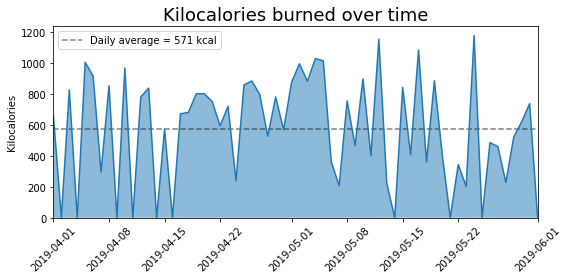

In [43]:
width = 800
height = 400
dpi = 100

plt.figure(figsize=(width/dpi, height/dpi))
plt.plot(daily['startTime'], daily['kiloCalories'])

plt.fill_between(x=daily['startTime'], 
                 y1=0, 
                 y2=daily['kiloCalories'], 
                 alpha=1/2)

daily_avg = daily['kiloCalories'].mean()

plt.hlines(xmin=daily['startTime'].min(),
           xmax=daily['startTime'].max(),
           y=daily_avg,
           linestyle='dashed',
           label=f'Daily average = {round(daily_avg)} kcal',
           alpha=1/2)

plt.title('Kilocalories burned over time', fontsize=18)
plt.xticks(rotation=45, horizontalalignment='center')
plt.xlim(daily['startTime'].min(), daily['startTime'].max())
plt.ylim(0, daily['kiloCalories'].max() * 1.05)
plt.ylabel('Kilocalories')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('./img/kilocalories_ts.png')
plt.show()

## Kilocalories by intensity

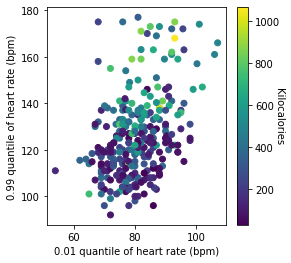

In [44]:
plt.scatter(df['heartRateQ1'], df['heartRateQ99'], c=df['kiloCalories'])
plt.xlabel('0.01 quantile of heart rate (bpm)')
plt.ylabel('0.99 quantile of heart rate (bpm)')

cbar = plt.colorbar()
cbar.set_label('Kilocalories', rotation=270)
plt.savefig('./img/intensity_scatter.png')
plt.show()

## Workouts by sport

We check how many workouts I completed.

In [45]:
stats = df[['sport', 'startTime']]
stats = stats.groupby(['sport'], as_index=False)
stats = stats.count()
stats = stats.rename(columns={'sport': 'Sport', 
                              'startTime': 'Count'})
stats = stats.sort_values('Count', ascending=False)

# stats = stats.style.background_gradient(cmap='YlGn', subset='Count')
# stats = stats.set_precision(2)

stats

,Sport,Count
4,walking,105
3,treadmill_running,90
2,strength_training,62
0,cycling,24
1,running,2


## By hour of day

We count workouts by hour of day.

In [46]:
by_hour = df[['startTime', 'sport']].copy()
by_hour['startHour'] = by_hour['startTime'].dt.hour
by_hour = by_hour.drop('startTime', axis=1)
by_hour = by_hour.groupby('startHour', as_index=False)
by_hour = by_hour.count()

all_hours = pd.DataFrame(range(0, 24), columns=['startHour'])

by_hour = pd.merge(all_hours, by_hour, how='left')
by_hour = by_hour.fillna(0)
by_hour = by_hour.sort_values('startHour')
by_hour = by_hour.rename(columns={'startHour': 'Hour of day', 
                                 'sport': 'Total workouts'})

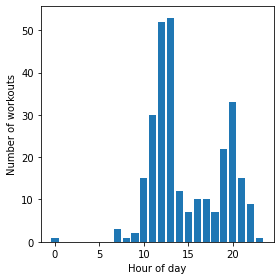

In [47]:
plt.bar(by_hour['Hour of day'], by_hour['Total workouts'])
plt.ylabel('Number of workouts')
plt.xlabel('Hour of day')
plt.tight_layout()
plt.savefig('./img/workouts_by_hour_of_day.png')
plt.show()

## By day of week

We count workouts by day of week.

In [48]:
by_day = df[['startTime', 'sport']].copy()
by_day['Day of week'] = pd.to_datetime(by_day['startTime']).dt.day_name()
by_day['Day number'] = pd.to_datetime(by_day['startTime']).dt.dayofweek
by_day = by_day.groupby(['Day of week', 'Day number'], as_index=False)
by_day = by_day.count()
by_day = by_day.drop('startTime', axis=1)
by_day = by_day.sort_values('Day number')
by_day = by_day.rename(columns={'sport': 'Total Workouts'})

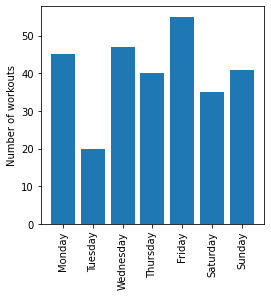

In [49]:
plt.bar(by_day['Day of week'], by_day['Total Workouts'])
plt.xticks(rotation=90)
plt.ylabel('Number of workouts')
plt.savefig('./img/workouts_by_day_of_week.png')
plt.show()

## Scatter plot of walks data

We plot `totalTime` versus `kiloCalories`. As can be seen their seems to exist a linear relationship between the two.

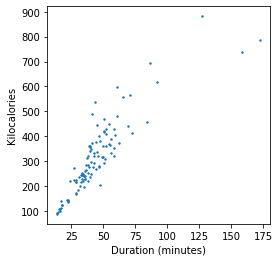

In [50]:
walking = df[df['sport'] == 'walking']
plt.scatter(walking['totalTime'], walking['kiloCalories'], s=2)
plt.xlabel('Duration (minutes)')
plt.ylabel('Kilocalories')
plt.savefig('./img/walks_kilocalories_vs_time.png')
plt.show()

We plot `heartRateAvg` against `kiloCalories`. Again we see a linear relationship although there are a couple of outliers

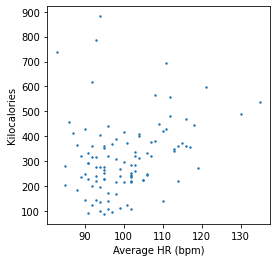

In [51]:
walking = df[df['sport'] == 'walking']
plt.scatter(walking['heartRateAvg'], walking['kiloCalories'], s=2)
plt.ylabel('Kilocalories')
plt.xlabel('Average HR (bpm)')
plt.savefig('./img/walks_kilocalories_vs_avg_hr.png')
plt.show()

# Regression

## Data preparation

Now we proceed to build a regression model to predict `kiloCalories` burned during a workout. First we create a subset of the original data.

In [52]:
reg_df = df[['kiloCalories', 'totalTime', 
             'heartRateQ99', 'isStrength', 'sport']].copy()

In [53]:
reg_df.head()

,kiloCalories,totalTime,heartRateQ99,isStrength,sport
0,245.00,33.33,115.00,False,walking
1,401.00,46.52,131.00,False,walking
2,336.00,45.15,120.00,False,walking
3,380.00,47.65,124.00,False,walking
4,358.00,39.67,141.00,False,walking


We remove the rows where `sport` is `running` because there were only two workouts recorded during the period in question.

In [54]:
reg_df = reg_df[reg_df['sport'] != 'running']

### Outliers

The data is cleansed of outliers using interquartile range.

In [55]:
def is_outlier_iqr(series, k=1.5):
    """
    Check if value is an outlier
    using interquartile range.
    """
    
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)        
    iqr = q3 - q1
    is_outlier = (series <= q1 - k * iqr) | (q3 + k * iqr <= series)
    
    return is_outlier

In [56]:
time_mask = is_outlier_iqr(series=reg_df['totalTime'])
kcal_mask = is_outlier_iqr(series=reg_df['kiloCalories'])
hr_mask = is_outlier_iqr(series=reg_df['heartRateQ99'])

In [57]:
reg_df = reg_df[~(time_mask | kcal_mask | hr_mask)]

## Histograms

We proceed to visualize histograms of each of the variables.

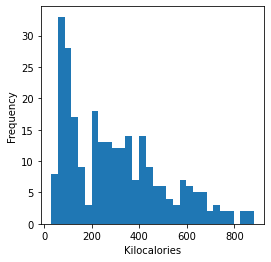

In [58]:
plt.hist(reg_df['kiloCalories'], bins=30)
plt.xlabel('Kilocalories')
plt.ylabel('Frequency')
plt.savefig('./img/kilocalories_histogram.png')
plt.show()

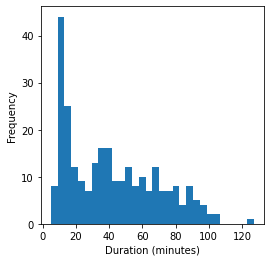

In [59]:
plt.hist(reg_df['totalTime'], bins=30)
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.savefig('./img/duration_histogram.png')
plt.show()

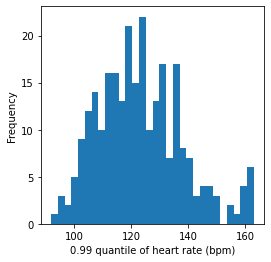

In [60]:
plt.hist(reg_df['heartRateQ99'], bins=30)
plt.xlabel('0.99 quantile of heart rate (bpm)')
plt.ylabel('Frequency')
plt.savefig('./img/q99_hr_histogram.png')
plt.show()

## Scatter plots

The plot below gives reason to suspect a linear relationship between `kiloCalories` and `totalTime`.

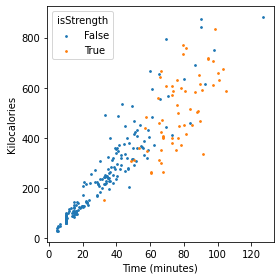

In [61]:
for val in [False, True]:
    tmp = reg_df[reg_df['isStrength'] == val]
    plt.scatter(tmp['totalTime'], 
                tmp['kiloCalories'],
                s=3, 
                label=val)
    
plt.xlabel('Time (minutes)')    
plt.ylabel('Kilocalories')    
plt.legend(title='isStrength', loc='best')
plt.tight_layout()
plt.savefig('./img/time_vs_kilocalories_scatter_by_strength.png')
plt.show()

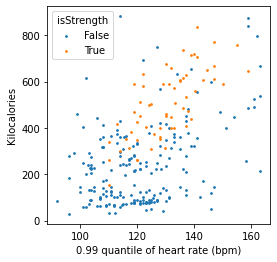

In [62]:
for val in [False, True]:
    tmp = reg_df[reg_df['isStrength'] == val]
    plt.scatter(tmp['heartRateQ99'],
                tmp['kiloCalories'],
                s=3, 
                label=val)

plt.xlabel('0.99 quantile of heart rate (bpm)')    
plt.ylabel('Kilocalories')
plt.legend(title='isStrength', loc='best')
plt.savefig('./img/99q_hr_vs_kilocalories_scatter_by_strength.png')
plt.show()

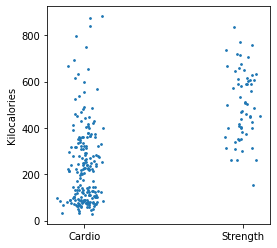

In [63]:
plt.scatter(reg_df['isStrength'] + np.random.normal(scale=1/20, size=len(reg_df)), 
            reg_df['kiloCalories'], s=3)

plt.ylabel('Kilocalories')
plt.xticks(ticks=[0, 1], labels=['Cardio', 'Strength'])
plt.savefig('./img/is_strength_vs_kilocalories_jitter.png')
plt.show()

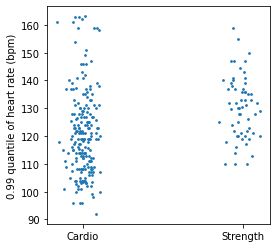

In [64]:
plt.scatter(reg_df['isStrength'] + np.random.normal(scale=1/20, size=len(reg_df)), 
            reg_df['heartRateQ99'], s=3)

plt.ylabel('0.99 quantile of heart rate (bpm)')
plt.xticks(ticks=[0, 1], labels=['Cardio', 'Strength'])
plt.savefig('./img/is_strength_vs_99q_hr_scatter.png')
plt.show()

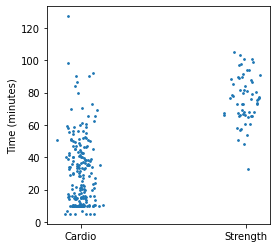

In [65]:
plt.scatter(reg_df['isStrength'] + np.random.normal(scale=1/20, size=len(reg_df)), 
            reg_df['totalTime'], s=3)

plt.ylabel('Time (minutes)')
plt.xticks(ticks=[0, 1], labels=['Cardio', 'Strength'])
plt.savefig('./img/is_strength_vs_time_jitter.png')
plt.show()

## Correlation

We convert binary the feature `isStrength` to integers for the rest of the analysis.

In [66]:
reg_df['isStrength'] = reg_df['isStrength'].astype(int)

We inspect the correlation matrix to check for multicollinearity. It should be noted that the correlation between `kiloCalories` and `totalTime` is quite high and this to be expected.

In [67]:
C = reg_df.corr(method='pearson')
# C = C.style.background_gradient(cmap='YlGn')
# C = C.set_precision(2)
C

,kiloCalories,totalTime,heartRateQ99,isStrength
kiloCalories,1.00,0.92,0.51,0.55
totalTime,0.92,1.00,0.28,0.69
heartRateQ99,0.51,0.28,1.00,0.26
isStrength,0.55,0.69,0.26,1.00


## Multicollinearity

We inspect the respect variance inflation factors and are happy to see that all are below 10.

In [68]:
tmp = reg_df.drop(['kiloCalories', 'sport'], axis=1)

vifs = []
for i in range(tmp.shape[1]):
    vif = variance_inflation_factor(tmp.to_numpy(), i)
    vifs.append(round(vif, 2))
    
vifs = pd.DataFrame(vifs, index=tmp.columns, columns=['VIF'])
vifs = vifs.sort_values('VIF', ascending=False)
vifs = vifs.reset_index()
vifs = vifs.rename(columns={'index': 'Variable'})

# vifs = vifs.style.background_gradient(cmap='OrRd')
# vifs = vifs.set_precision(2)

vifs

,Variable,VIF
0,totalTime,6.30
1,heartRateQ99,3.90
2,isStrength,2.41


## Modelling

Before the actual modelling we prepare a function to calculate `RMSE` to compare models and extract the true `kiloCalories` into a separate array.

In [69]:
y_true = reg_df['kiloCalories'].to_numpy()

In [70]:
def calc_rmse(y_true, y_pred):
    x = np.sqrt(np.mean(np.power(y_true - y_pred, 2)))
    return round(x, 4)

In [71]:
all_results = []

### Time only

We start the modelling section of by building the simplest model that comes to mind: predict `kiloCalories` using `totalTime`.

In [72]:
formula = 'kiloCalories ~ totalTime'
mdl_time = smf.ols(formula=formula, data=reg_df)
mdl_time = mdl_time.fit()
mdl_time.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.849    
Dependent Variable: kiloCalories     AIC:                3070.3883
Date:               2020-10-06 14:50 BIC:                3077.5477
No. Observations:   265              Log-Likelihood:     -1533.2  
Df Model:           1                F-statistic:        1483.    
Df Residuals:       263              Prob (F-statistic): 4.24e-110
R-squared:          0.849            Scale:              6254.0   
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept      17.1713    8.7686   1.9583  0.0513  -0.0942  34.4369
totalTime       6.7722    0.1759  38.5076  0.0000   6.4260   7.1185
------------------------------------------------------------------
Omnibus:               35.699       Durbin-Watson:          1.803 
Prob(Omnibus):         0.000        Jarque-Bera (JB):       92.425
Skew:                  0.605        Prob(JB):               0.000 
Kurtosis:              5.628        Condition No.:          90    
==================================================================

"""

In [73]:
y_pred = mdl_time.predict(reg_df)
rmse = calc_rmse(y_pred, y_true)
all_results.append((rmse, formula))

In [74]:
print(rmse)

78.7832


### By sport

The next regression we are going to do will be univariate regression separately for each sport, this will help us answer the question which sport is the most effective at burning calories during a workout.

In [75]:
all_sports = sorted(reg_df['sport'].unique())
reg_sports_res = []

# For all sport do simple linear regression
for sport in all_sports:
    tmp = reg_df[reg_df['sport'] == sport]
    formula = 'kiloCalories ~ totalTime'
    mdl_sport = smf.ols(formula=formula, data=tmp)
    mdl_sport = mdl_sport.fit()
    sport_stats = [formula, sport] + list(mdl_sport.params) + [mdl_sport.rsquared]    
    reg_sports_res.append(sport_stats)
    
cols = ['Formula', 'Sport', 'Intercept', 'Slope', 'R squared']

reg_sports_res = pd.DataFrame(reg_sports_res, columns=cols)    
reg_sports_res = reg_sports_res.sort_values(['Slope'], ascending=False)
reg_sports_res = reg_sports_res.reset_index(drop=True)

readme_df = reg_sports_res.copy().round(2)

# reg_sports_res = reg_sports_res.style.background_gradient(cmap='YlGn', subset='Slope')
# reg_sports_res = reg_sports_res.set_precision(2)

reg_sports_res

,Formula,Sport,Intercept,Slope,R squared
0,kiloCalories ~ totalTime,treadmill_running,-21.23,10.14,0.96
1,kiloCalories ~ totalTime,cycling,-9.73,7.44,0.98
2,kiloCalories ~ totalTime,walking,12.59,6.95,0.82
3,kiloCalories ~ totalTime,strength_training,-12.73,6.76,0.44


## Time and heart rate

We try to enhance the model by adding `heartRateQ99`.

In [76]:
formula = 'kiloCalories ~ totalTime + heartRateQ99'
mdl_time_and_hr = smf.ols(formula=formula, data=reg_df)
mdl_time_and_hr = mdl_time_and_hr.fit()
mdl_time_and_hr.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:               OLS              Adj. R-squared:     0.918    
Dependent Variable:  kiloCalories     AIC:                2910.3348
Date:                2020-10-06 14:50 BIC:                2921.0740
No. Observations:    265              Log-Likelihood:     -1452.2  
Df Model:            2                F-statistic:        1472.    
Df Residuals:        262              Prob (F-statistic): 3.32e-143
R-squared:           0.918            Scale:              3405.9   
-------------------------------------------------------------------
               Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
Intercept    -420.7741  30.1664 -13.9484 0.0000 -480.1736 -361.3746
totalTime       6.2025   0.1353  45.8339 0.0000    5.9361    6.4690
heartRateQ99    3.7435   0.2519  14.8636 0.0000    3.2476    4.2394
-------------------------------------------------------------------
Omnibus:              14.259        Durbin-Watson:           1.917 
Prob(Omnibus):        0.001         Jarque-Bera (JB):        21.717
Skew:                 -0.355        Prob(JB):                0.000 
Kurtosis:             4.210         Condition No.:           1106  
===================================================================
* The condition number is large (1e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

In [77]:
y_pred = mdl_time_and_hr.predict(reg_df)
rmse = calc_rmse(y_pred, y_true)
all_results.append((rmse, formula))

In [78]:
print(rmse)

58.0287


## Time with random effects by workout type

In [79]:
formula = 'kiloCalories ~ totalTime + heartRateQ99'
re_formula = ' ~ totalTime'
group = 'isStrength'

mdl_time_with_hr_re = smf.mixedlm(formula=formula, 
                  data=reg_df, 
                  groups=reg_df[group], 
                  re_formula=re_formula)

mdl_time_with_hr_re = mdl_time_with_hr_re.fit(method='lbfgs')
mdl_time_with_hr_re.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                MixedLM     Dependent Variable:     kiloCalories
No. Observations:     265         Method:                 REML        
No. Groups:           2           Scale:                  2570.3031   
Min. group size:      61          Log-Likelihood:         -1416.8825  
Max. group size:      204         Converged:              Yes         
Mean group size:      132.5                                           
----------------------------------------------------------------------
                       Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------
Intercept             -475.991   65.174 -7.303 0.000 -603.730 -348.252
totalTime                6.755    0.858  7.874 0.000    5.074    8.437
heartRateQ99             3.933    0.220 17.868 0.000    3.502    4.365
Group Var              210.604   51.671                               
Group x totalTime Cov    9.904    0.550                               
totalTime Var            0.466    0.036                               
======================================================================

"""

In [80]:
y_pred = mdl_time_with_hr_re.predict(reg_df)
rmse = calc_rmse(y_pred, y_true)
all_results.append((rmse, formula, re_formula, group))

In [81]:
print(rmse)

60.9247


## Model evaluation

We compare the linear models created earlier:

In [82]:
comp_df = pd.DataFrame(all_results, columns=['RMSE', 'Formula', 'Random effects', 'Groups'])
comp_df = comp_df.sort_values('RMSE')

# comp_df = comp_df.style.background_gradient(cmap='OrRd', subset='RMSE')
# comp_df = comp_df.set_precision(2)

comp_df

,RMSE,Formula,Random effects,Groups
1,58.03,kiloCalories ~ totalTime + heartRateQ99,None,None
2,60.92,kiloCalories ~ totalTime + heartRateQ99,~ totalTime,isStrength
0,78.78,kiloCalories ~ totalTime,None,None


For further evaluation we choose the random effects model.

In [83]:
mdl = mdl_time_with_hr_re
residuals = mdl_time_with_hr_re.resid

### Visual inspection

We proceed to inspect the residuals of the model. First we view the histogram of the residuals. It can be seen that it looks normal.

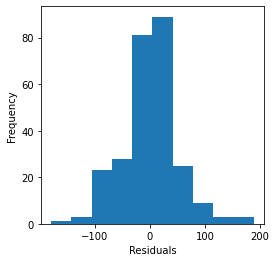

In [84]:
plt.hist(residuals)
plt.ylabel('Frequency')
plt.xlabel('Residuals')
plt.savefig('./img/mdl_residuals.png')
plt.show()

The next plot is a qqplot created to visually inspect the normality of the residuals. We see 3 nasty outliers in the top right corner.

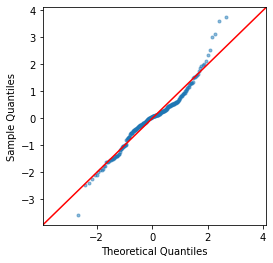

In [85]:
plt.figure()
ax = plt.gca()

qqplot(data=mdl.resid, 
       ax=ax, 
       color='#1f77b4', 
       markersize=3, 
       line='45', 
       fit=True, 
       alpha=1/2)

plt.savefig('./img/mdl_qq.png')
plt.show()

The third plot we make is a plot of the standardized residuals to check for homoskedasticity. Again we see the same outliers as on the plot above.

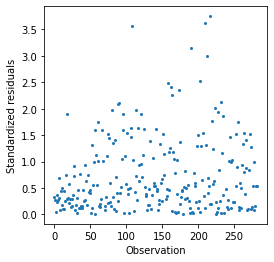

In [86]:
residuals_std = np.abs((residuals - np.mean(residuals)) / np.std(residuals))
plt.plot(residuals_std, 'o', markersize=2)
plt.xlabel('Observation')
plt.ylabel('Standardized residuals')
plt.savefig('./img/mdl_residuals_std.png')
plt.show()

Finally we compare the predicted `kiloCalories` with the actual values.

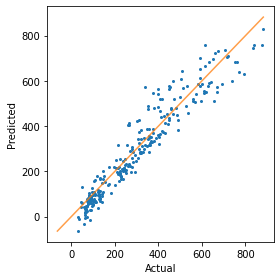

In [87]:
y_pred = mdl.predict(reg_df)
y_pred = y_pred.to_numpy().reshape(len(y_pred))

m = np.min(np.hstack([y_true, y_pred]))
M = np.max(np.hstack([y_true, y_pred]))

x = np.linspace(m, M, len(y_pred))
plt.plot(y_true, y_pred, 'o', markersize=2)
plt.plot(x,x, alpha=3/4)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.tight_layout()
plt.savefig('./img/mdl_predicted_vs_actual.png')
plt.show()

The next step is to take a look at the data points with the biggest error. As can be seen the model has issues predicting strength training workouts.

In [88]:
errors = reg_df.copy()
errors['kiloCaloriesPredicted'] = mdl.predict(reg_df)

errors['error'] = np.abs(errors['kiloCalories'] - errors['kiloCaloriesPredicted'])

errors = errors.sort_values('error', ascending=False)
errors = errors.reset_index(drop=True)

order = ['kiloCaloriesPredicted',
         'kiloCalories', 
         'error',
         'totalTime',
         'isStrength']

errors = errors[order]

errors = errors.head(5)

errors = errors.style.background_gradient(cmap='OrRd', subset='error')
errors = errors.set_precision(2)

errors

,kiloCaloriesPredicted,kiloCalories,error,totalTime,isStrength
0,573.76,338.00,235.76,91.35,1
1,546.98,373.00,173.98,78.07,1
2,631.69,795.00,163.31,69.65,0
3,562.00,400.00,162.00,76.80,1
4,412.98,263.00,149.98,67.55,1


# Summary

In [89]:
# Make table for README
# print(tabulate.tabulate(by_sport.values, by_sport.columns, tablefmt="pipe"))

In [90]:
# Make table for README
# print(tabulate.tabulate(readme_df.values, readme_df.columns, tablefmt="pipe"))

* In this project I define a `workout` as each instance in time when my watch was recording me.

* I downloaded data generated by my Polar watch that tracks `heart rate` and estimates burned `kilocalories` during workouts.

* The data came in the form of `.json` files which were read, transformed and cleaned with `pandas`. 

* The clean dataset contains `283` workouts over a nearly one year period during which I burned roughly `12kg` of body fat.

| Sport             |   Total kilocalories |   Total kilograms |
|:------------------|---------------------:|------------------:|
| walking           |                33080 |              4.3  |
| strength_training |                31547 |              4.1  |
| treadmill_running |                19825 |              2.57 |
| cycling           |                 4029 |              0.52 |
| running           |                  940 |              0.12 |

* The timing of my workouts appears to follow a `bimodal distribution` with peaks at `12:00` and `20:00`.

<!-- ![image](https://github.com/besiobu/data-science-portfolio/blob/master/polar/img/workouts_by_hour_of_day.png) -->

* After further transforming the data, I find that the `duration` of a workout and `kilocalorie`'s burned have a `0.92` correlation. 

<!-- ![image](https://github.com/besiobu/data-science-portfolio/blob/master/polar/img/time_vs_kilocalories_scatter_by_strength.png) -->

* Several linear regressions were performed. 

* `kilocalories ~ duration` on the entire dataset achieved `R^2 = 0.85` and `RMSE = 79`.

* Regressions were performed on subsets of the data, specifically by sport - the highest slope is `10.14 kiloCalories` per minute.

| Formula                  | Sport             |   Intercept |   Slope |   R squared |
|:-------------------------|:------------------|------------:|--------:|------------:|
| kilo_calories ~ total_time | treadmill_running |      -21.23 |   10.14 |        0.96 |
| kilo_calories ~ total_time | cycling           |       -9.73 |    7.44 |        0.98 |
| kilo_calories ~ total_time | walking           |       12.59 |    6.95 |        0.82 |
| kilo_calories ~ total_time | strength_training |      -12.73 |    6.76 |        0.44 |

* A `linear mixed model with random effects` was created and validated. It achieved a `RMSE = 61` and normal looking residuals.

<!-- ![image](https://github.com/besiobu/data-science-portfolio/blob/master/polar/img/mdl_predicted_vs_actual.png) -->

* The biggest `errors` made by the `mixed model` was on `strength training` data points.